# Scientific Computing - Practice sessions  : Audio command recognition by DTW and classification

**Names :*Thang Nguyen, Clement Poull*

The Practice sessions will permit testing the dynamic programming algorithm (DTW) seen in Exercise session (TD) and then implement an audio recognition system for isolated words (constituting orders for drones).


These sessions are divided into 3 parts: 
- Part I: DTW and application of the TD
- Part II: Audio control word recognition system
- Part III: Comparison of dynamic programming with a classification method after data pre-processing by PCA

For **parts II and III**, you will test the audio recognition system on two sets of voices that will serve as a learning base (references) and a test base (sounds to be recognized) respectively. The list of the 13 drone commands are: *Landing, Takeoff, Takeoff, Advance, Right turn, Backward, Left turn, Right, Flip, Left, Stop, Higher, Lower and State of Emergency.*

To do this, you must per group of 2 students (number of students **MANDATORY**):
1. **Propose a study** that you will detail on a report.
For example, *influence male voices VS female voices, compare your own voices to the database, test the impact of different background noises on recognition...*];
2. Create, according to the objective of your study, your own learning base and test base from the proposed corpus and the voices and sounds you have recorded   [*audio parameters: 16 KHz, mono, 16 bits, *.wav format**];
3. Test the DTW and a classification method with pre-processing by PCA;
4. Evaluate the results; 
5. Write a pdf report presenting the study, the results by the 2 methods and your comments and conclusions on your study (Max. length: 8 pages).



In [767]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array, zeros, full, argmin, inf, ndim
import scipy
import sklearn
import math
import IPython.display as ipd
from scipy.spatial import distance
import numpy as np
from sklearn.model_selection import train_test_split
import noisereduce as nr
import librosa
import librosa.display
from ipykernel import kernelapp as app
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
import os
import glob2
import progressbar
from shutil import copyfile
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scikitplot as skplt
labels = ["tournegauche","tournedroite","recule","plushaut",
          "plusbas","gauche","faisunflip","etatdurgence","droite",
          "decollage","avance","atterrissage","arretetoi"]

# Part I: Implementation of the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation and display of the cost matrix defined in TD. 

2. In order to easily adapt the cost calculation according to the nature of the data (and therefore the distances used), write a function for each distance (Euclidean, letters, sounds) that will appear as a parameter of the DTW function.

In [652]:
def dtw(s1,s2,dist=distance.euclidean,l_const=np.array([1,1,1]),g_const = None,plot=False):
    """
    :ts1: float - timeseries1
    :ts2: float - timeseries2
    :dist: lamda - distance
    """

    s1 = np.insert(s1, 0, 0,axis=0)
    s2 = np.insert(s2, 0, 0,axis=0)
    m = len(s1)
    n = len(s2)
    
    
    DTW = np.full((n,m),float("inf"),dtype=float)
    
    DTW[0,0] = 0
    
    for i in range(1,n):
        if g_const != None: 
            newms = max(1,i-g_const)
            newme = min(m,i+g_const)
        else: 
            newms = 1;
            newme = m;
            
        for j in range(newms,newme):
            cost = dist(s1[j],s2[i])
            DTW[i,j] = np.min(np.array([DTW[i-1,j],DTW[i-1,j-1], DTW[i,j-1]])
                              + cost*l_const)

    path = list()
    path.append([n-1,m-1,DTW[n-1,m-1]])
    i = n-1
    j = m-1
    while (True):
        k = np.argmin([DTW[i-1,j],DTW[i-1,j-1],DTW[i,j-1]])
        if k==0:
            path.append([i-1,j,DTW[i-1,j]])
            i = i-1
        elif k==1:
            path.append([i-1,j-1,DTW[i-1,j-1]])
            j = j-1
            i = i-1
        else:
            path.append([i,j-1,DTW[i,j-1]])
            j = j-1
        if i==0 and j==0:
            break
    path = np.array(path)
    if plot:
        print("distant=",DTW[n-1,m-1]/(n+m - 2))
        plt.imshow(DTW, origin='lower', interpolation='nearest')
        plt.plot(path[:,1], path[:,0], 'w')
        plt.show()

    return DTW[n-1,m-1]/(n+m - 2)#, path, DTW

distant= 3.6


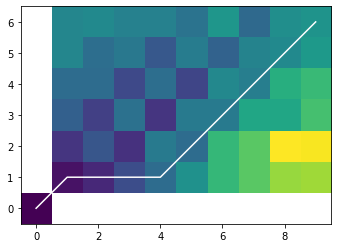

3.6

In [653]:
x = np.array([-2,10,-10,15,-13,20,-5,14,2])
y = np.array([3,-13,14,-7,9,-2])
euclidean_norm = lambda x, y: np.abs(x - y)
dtw(x.T,y.T,dist=euclidean_norm,g_const=None,plot=True)

distant= 0.16666666666666666


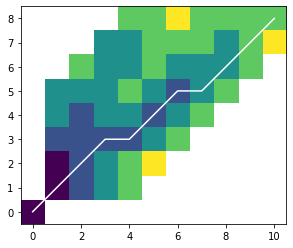

0.16666666666666666

In [654]:
x = np.array(['A','T','G','G','T','A','C','G','T','C'])
y = np.array(['A','A','G','T','A','G','G','C'])
symbols_norm = lambda x, y: 0 if x == y else 1
dtw(x.T,y.T,dist=symbols_norm,g_const=4,plot=True)

#### Application to exercises 

1. Test your programs on the exercises seen in TD. 

2. Modify the local constraints, i.e. the weights according to the directions. 

3. Add the consideration of global constraints, i. e. non-calculation when the boxes are too far from the diagonal (see exercise TD DNA sequence). From which position do global constraints not change the results?

# Part II: Audio control word recognition system

On the shared space, you will find audio recordings of command words for a quadricopter drone composed of several male french speakers (noted M01...M13) and female french speakers (F01...F05).

You can thus divide all the data into learning bases that will serve as references and test bases to evaluate recognition by dynamic programming.

**Audio file upload:**

Original wav


reudce wav


reudce noise and trim silent wav


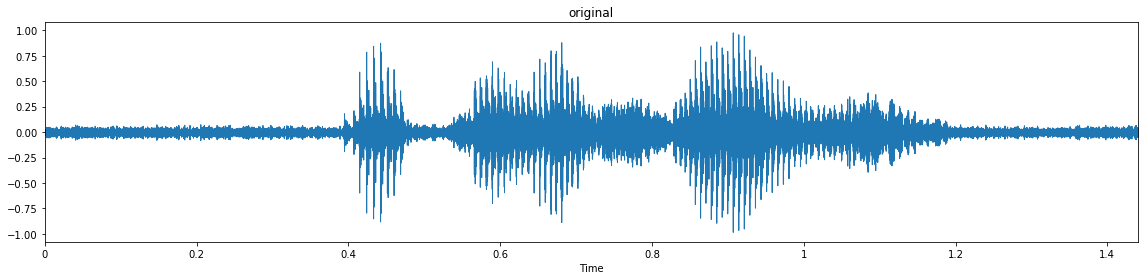

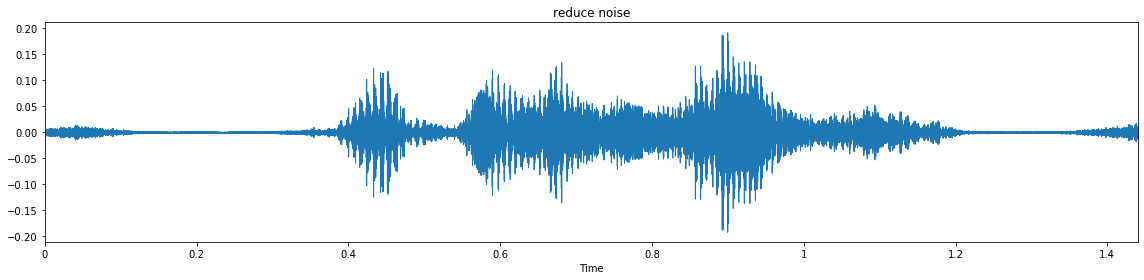

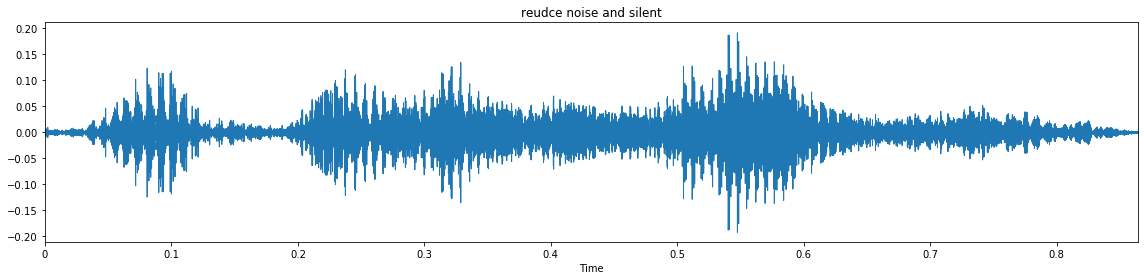

In [679]:
y, sr = librosa.load("corpus/drone_noise/M01_atterrissage.wav",sr=16000,dtype=np.float16, res_type='kaiser_fast')
y1 = nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
yt, index = librosa.effects.trim(y1,top_db=15)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.title('original')
print("Original wav")
ipd.display(ipd.Audio(data=y, rate=16000))
plt.tight_layout()

plt.figure(figsize=(16, 4))
librosa.display.waveplot(y1, sr=sr)
plt.title('reduce noise')
print("reudce wav")
ipd.display(ipd.Audio(data=y1, rate=16000))
plt.tight_layout()

plt.figure(figsize=(16, 4))
librosa.display.waveplot(yt, sr=sr)
plt.title('reudce noise and silent')
print("reudce noise and trim silent wav")
ipd.display(ipd.Audio(data=yt, rate=16000))
plt.tight_layout()

In [666]:
def wav2mfcc(file_path, max_len=50, n_mfcc = 12, hop_length=1024,pad = False, delta = False, delta_delta = False):
    #convert wav to feature matrix of wav composed by mfcc + delta + delta2
    #perameters:
    # - file_path: the path of wav
    # - max_len: the width of feature matrix
    # - n_mfcc: number of coefficients
    # - hop_length: width of frames and strides
    # - pad: fix size of feature matrix
    # - delta, delta2: use Delta Coefficients
    #return: - yr: audio time series
    #        - mfcc with shape(n_mfcc*3,max_len) if delta, delta2 are True
    
    # load wav file
    wave, sr = librosa.load(file_path, sr=16000,dtype=np.float16, res_type='kaiser_fast')
    # reduce noise
    yrn = nr.reduce_noise(audio_clip=wave, noise_clip=wave, verbose=False)
    # trim silent
    yf, index = librosa.effects.trim(yrn,top_db=20)
    
    #feature extraction
    mfcc = librosa.feature.mfcc(y=yf, sr=16000,hop_length=hop_length, n_mfcc=n_mfcc)
    
    if delta:
        mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
    if delta_delta:
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2,mode='nearest')
    
    if not pad:
        return yf,mfcc
    #padding zero vector two sides of mfcc to fix size.
    # |000feature000| = max_len
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        a,b=0,0
        if pad_width % 2 == 0:
            a = pad_width//2
            b = pad_width//2
        else:
            a = pad_width//2
            b = pad_width//2 +1
        mfcc = np.pad(mfcc, pad_width=((0, 0), (a, b)), mode='constant')
        if delta:
            mfcc_delta = np.pad(mfcc_delta, pad_width=((0, 0), (a, b)), mode='constant')
        if delta_delta:
            mfcc_delta2 = np.pad(mfcc_delta2, pad_width=((0, 0), (a, b)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
        if delta:
            mfcc_delta = mfcc_delta[:, :max_len]
        if delta_delta:
            mfcc_delta2 = mfcc_delta2[:, :max_len]

    #concatenate mfcc + delta + delta 2
    if delta and delta_delta:
        return yf,np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    elif delta and not delta_delta:
        return yf,np.concatenate((mfcc, mfcc_delta))
    else:
        return yf,mfcc

The following lines of code allow you to transform the audio file into a matrix of parameters called MFCC (Mel Frequency Cepstral Coefficient) using the *librosa* python library. These settings are used to extract the best possible frequency voice content from the audio signal.

The output matrix is composed of as many column vectors as analysis frames. The number of lines corresponds to the size of the representative vector: here 12.


In [667]:
def print_plot_play(y, mfcc, text=''):
    print('%s, x.shape = %s, x.dtype = %s' % (text, mfcc.shape, y.dtype))
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title(l)
    plt.colorbar()
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(y, sr=16000)
    plt.title(l)
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=y, rate=16000))

### **MFCC extraction and Data preprocessing***
We has process data:
- reduce noise
- trim silent
- get feature matrix
- pad zero vector two sides of feature matrix

gauche M02_gauche.wav, x.shape = (12, 9), x.dtype = float32


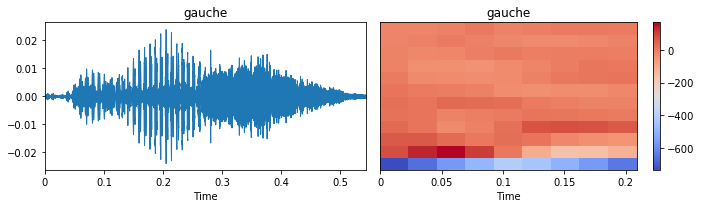

recule M01_recule.wav, x.shape = (12, 9), x.dtype = float32


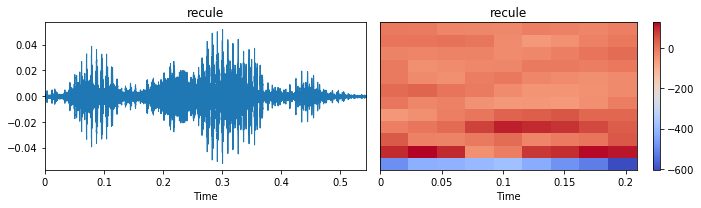

droite NM03_droite.wav, x.shape = (12, 6), x.dtype = float32


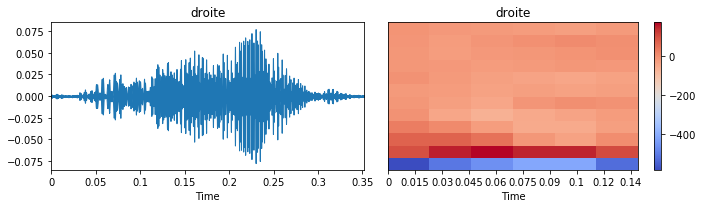

decollage F01_decollage.wav, x.shape = (12, 11), x.dtype = float32


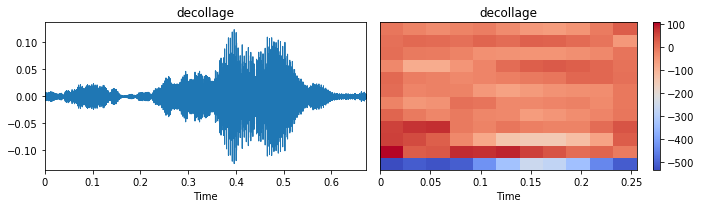

faisunflip M03_faisunflip.wav, x.shape = (12, 8), x.dtype = float32


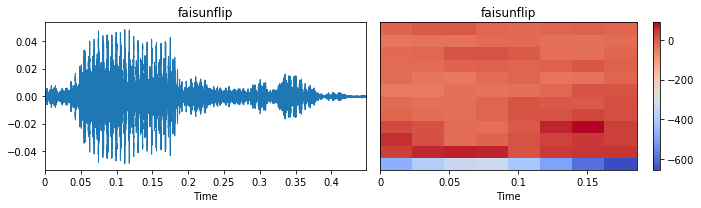

atterrissage M02_atterrissage.wav, x.shape = (12, 60), x.dtype = float32


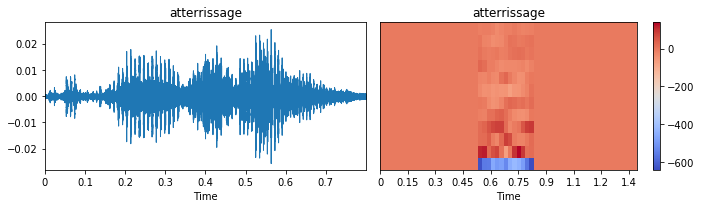

etatdurgence M08_etatdurgence.wav, x.shape = (12, 60), x.dtype = float32


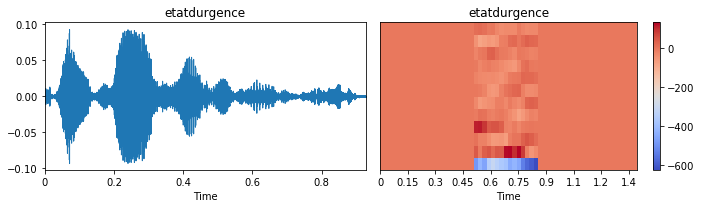

avance M04_avance.wav, x.shape = (12, 60), x.dtype = float32


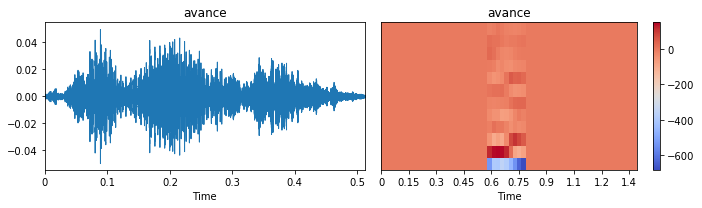

plusbas F02_plusbas.wav, x.shape = (12, 60), x.dtype = float32


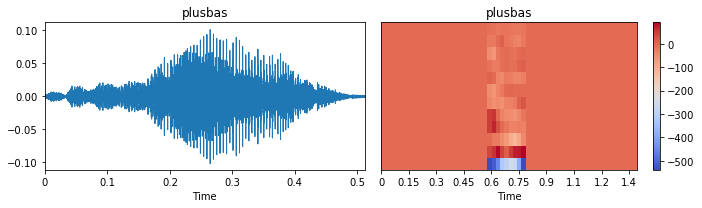

tournegauche M09_tournegauche.wav, x.shape = (12, 60), x.dtype = float32


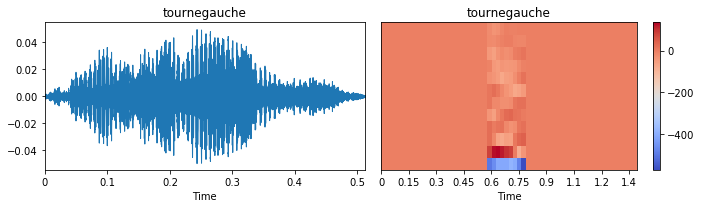

tournedroite M08_tournedroite.wav, x.shape = (12, 60), x.dtype = float32


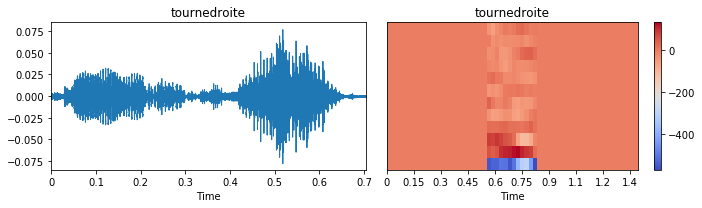

arretetoi M11_arretetoi.wav, x.shape = (12, 60), x.dtype = float32


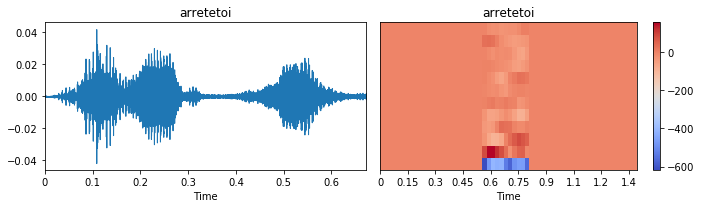

plushaut M01_plushaut.wav, x.shape = (12, 60), x.dtype = float32


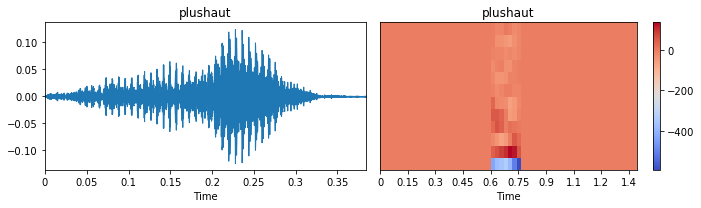

In [672]:
m = 0
pad = False
for i,l in enumerate(os.listdir("data")):
    if l == '.DS_Store':
        continue
    if (i == 6):
        pad = True
    y, mfcc = wav2mfcc('data/'+l+'/'+os.listdir("data/"+l)[m],max_len=60,
                       n_mfcc = 12,hop_length=1024,pad=pad,delta=False, delta_delta=False)
    print_plot_play(y,mfcc,text=l+' '+os.listdir("data/"+l)[m])

**Application of DTW**

1. Carry out a study that you will detail on a report (for example, *influence male voices VS female voices, compare your own voice with the database, test the impact of different background noises on recognition...*) and create your own learning database and test database from the corpus and the voices and noises you have recorded. 

2. Apply DTW to your corpora.

**Settings for audio recordings of your personal voices:**

16 KHz, mono, 16 bits, *.wav* format


Firstly, we evalute performance of DTW algorithm with 3 audio file are: M11_etatdurgence.wav,M12_droite.wav,M12_etatdurgence.wav 

In [684]:
_,mfcc = wav2mfcc("M11_etatdurgence.wav")
_,mfcc1 = wav2mfcc("M12_droite.wav")
_,mfcc2 = wav2mfcc("M12_etatdurgence.wav")
print(mfcc.shape,mfcc1.shape,mfcc2.shape)

(12, 14) (12, 5) (12, 11)


distant= 106.27888334645608


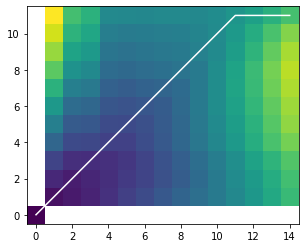

In [685]:
dtw(mfcc.T, mfcc2.T,dist=distance.euclidean,plot=True);

distant= 159.4968127922591


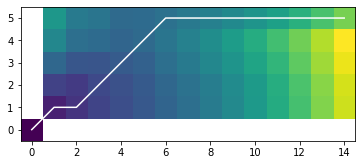

In [686]:
dtw(mfcc.T, mfcc1.T,dist=distance.euclidean,plot=True);

**Assessment of recognition**

1. Calculate the system confusion matrix (in line with the references and in column the system outputs). 
You can use the *confusion_matrix* function of the *sklearn* library.


2. Calculate the recognition score: number of well recognized files on number of tested files. 

*Verification:*
- if you use the M01 reference and test file, you must get no errors.
- if you use as M01 reference file and M02 test file, you must get two errors.

**Then, we evaluate performance of DTW algorithm with:**
- Data without noise
     + only female voices without noise
     + only male voices without noise
     + training set is male voice and test set is female voice
- Full data

In [733]:
def collect_data(dataset_name,gender=None):
    X = []
    y = []
    for file in os.listdir(dataset_name):
        sample_class = file.split('_')[1]
        if gender == None:#all
            pass
        elif gender not in file.split('_')[0]:
            continue
        _,mfcc = wav2mfcc(dataset_name+file,pad=False)
        X.append(mfcc)
        y.append(labels.index(sample_class[:len(sample_class)-4]))
    return X,y

In [717]:
def recognie(X_train,X_test,y_train):
    # this method allows recognie y_test base on (X_train,y_train)
    # return: y_pred of X_test
    y_pred = []

    bar = progressbar.ProgressBar(maxval=len(X_test))
    for sample in bar(X_test):
        min_dist = np.inf
        predicted_class = None
        for other, other_class in zip(X_train, y_train):
            distance= dtw(sample.T, other.T)
            if distance < min_dist:
                min_dist = distance
                predicted_class = other_class
        y_pred.append(predicted_class)
    return y_pred

def plot_eval(y_test, y_pred,title):
    # this function allows plot confusion matrix and some report like accuracy, precision,recall,f1-score.
    
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,figsize=(10,10),title=title)
    plt.show()
    print(sklearn.metrics.classification_report(y_test, y_pred,digits=2))

**Evaluate dtw on female and male voices independently without noise**

In [705]:
XMale,yMale = collect_data(dataset_name="corpus/drone_withoutnoise/", gender='M')
XFemale,yFemale = collect_data(dataset_name="corpus/drone_withoutnoise/", gender='F')

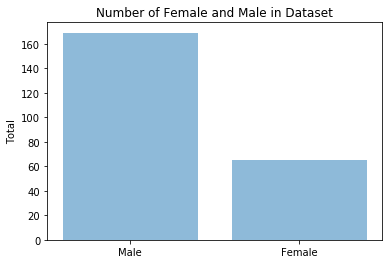

In [700]:
plt.bar([0,1], [len(yMale),len(yFemale)], align='center', alpha=0.5)
plt.xticks([0,1], ['Male','Female'])
plt.ylabel('Total')
plt.title('Number of Female and Male in Dataset')
plt.show()

In [752]:
XM_train,XM_test,yM_train, yM_test =train_test_split(XMale, yMale, test_size=0.3,random_state=42)
XF_train,XF_test,yF_train, yF_test =train_test_split(XFemale, yFemale, test_size=0.2,random_state=42)

In [753]:
yM_pred = recognie(XM_train,XM_test,yM_train)

100% |########################################################################|


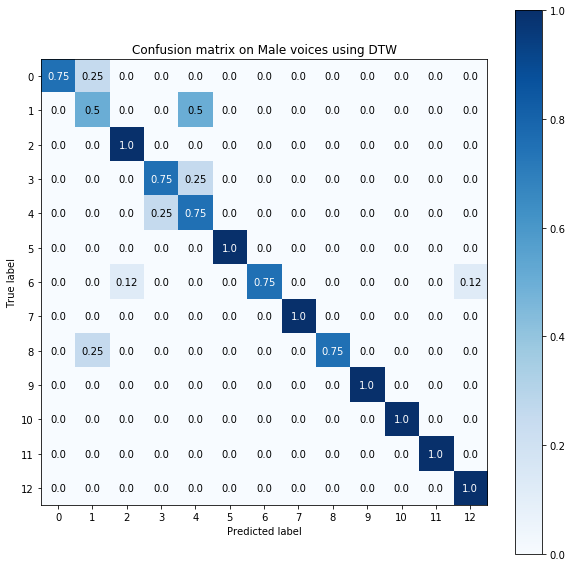

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.50      0.50      0.50         4
           2       0.83      1.00      0.91         5
           3       0.75      0.75      0.75         4
           4       0.50      0.75      0.60         4
           5       1.00      1.00      1.00         2
           6       1.00      0.75      0.86         8
           7       1.00      1.00      1.00         1
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.80      1.00      0.89         4

    accuracy                           0.84        51
   macro avg       0.88      0.87      0.86        51
weighted avg       0.87      0.84      0.85        51



In [754]:
plot_eval(yM_test,yM_pred,title="Confusion matrix on Male voices using DTW")

In [755]:
yF_pred = recognie(XF_train,XF_test,yF_train)

100% |########################################################################|


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


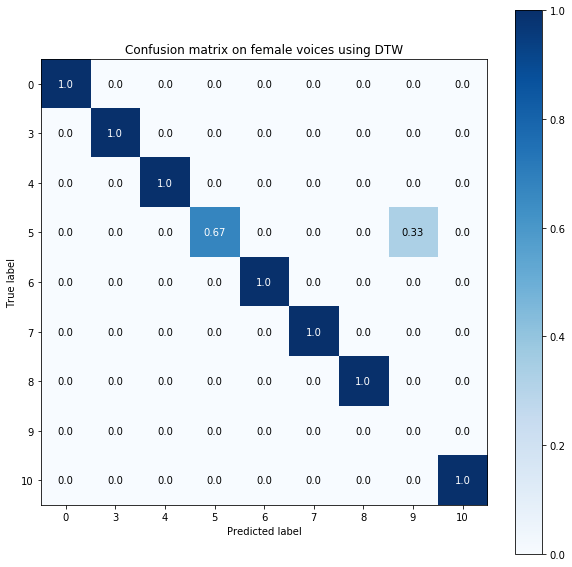

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1

    accuracy                           0.92        13
   macro avg       0.89      0.85      0.87        13
weighted avg       1.00      0.92      0.95        13



/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [756]:
plot_eval(yF_test,yF_pred,title="Confusion matrix on female voices using DTW")

**Training set is male voice and test set is female voice**

In [730]:
yFemale_pred = recognie(XMale,XFemale,yMale)

100% |########################################################################|


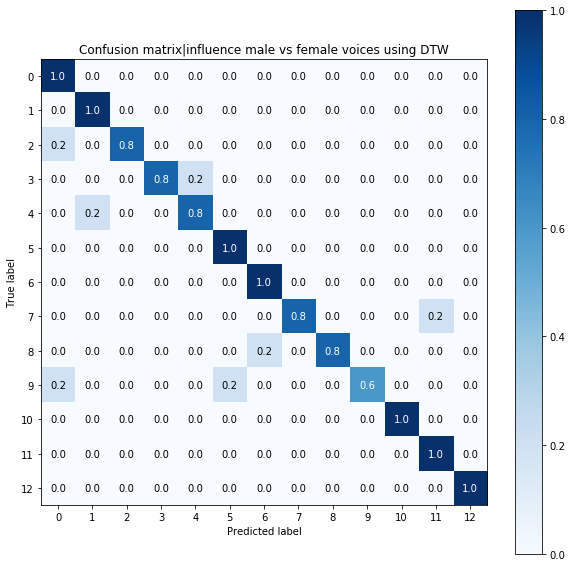

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       0.80      0.80      0.80         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       1.00      0.80      0.89         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         5

    accuracy                           0.89        65
   macro avg       0.91      0.89      0.89        65
weighted avg       0.91      0.89      0.89        65



In [820]:
plot_eval(yFemale,yFemale_pred,title="Confusion matrix|influence male vs female voices using DTW")

**Apply DTW for learning set is without noise and test on data noise dataset**

In [759]:
X,y = collect_data(dataset_name="corpus/drone_withoutnoise/")
XN,yN = collect_data(dataset_name="corpus/drone_noise/")

In [760]:
yN_pred = recognie(X,XN,y)

100% |########################################################################|


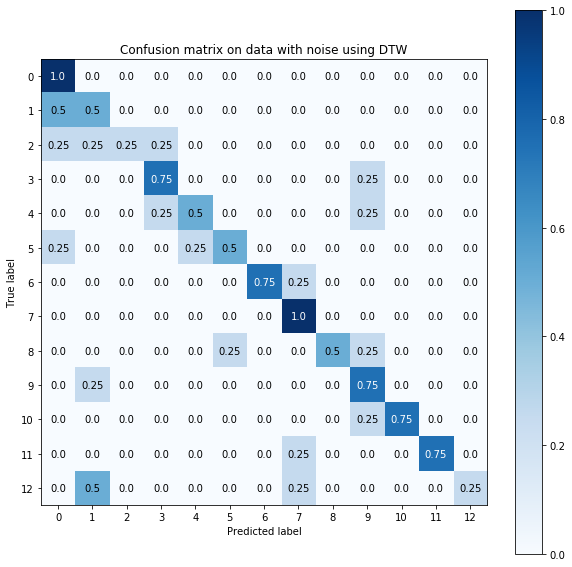

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.33      0.50      0.40         4
           2       1.00      0.25      0.40         4
           3       0.60      0.75      0.67         4
           4       0.67      0.50      0.57         4
           5       0.67      0.50      0.57         4
           6       1.00      0.75      0.86         4
           7       0.57      1.00      0.73         4
           8       1.00      0.50      0.67         4
           9       0.43      0.75      0.55         4
          10       1.00      0.75      0.86         4
          11       1.00      0.75      0.86         4
          12       1.00      0.25      0.40         4

    accuracy                           0.63        52
   macro avg       0.75      0.63      0.63        52
weighted avg       0.75      0.63      0.63        52



In [761]:
plot_eval(yN,yN_pred,title="Confusion matrix on data with noise using DTW")

**Apply DTW for all dataset**

In [762]:
X.extend(XN)
y.extend(yN)
X_train,X_test,y_train, y_test =train_test_split(X, y, test_size=0.3,random_state=42)

100% |########################################################################|


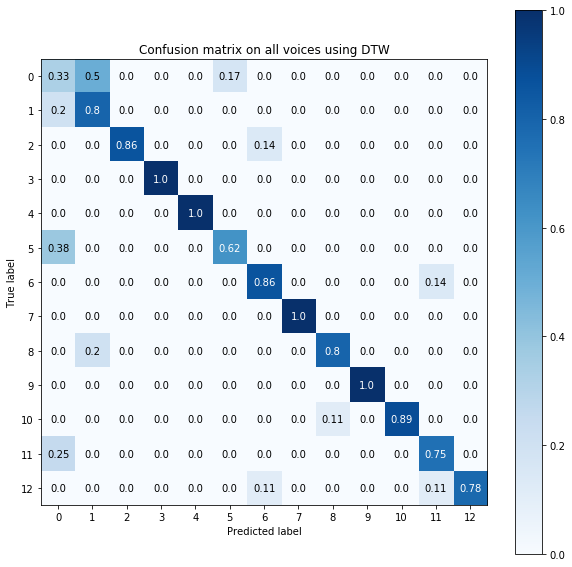

              precision    recall  f1-score   support

           0       0.29      0.33      0.31         6
           1       0.50      0.80      0.62         5
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       0.83      0.62      0.71         8
           6       0.75      0.86      0.80         7
           7       1.00      1.00      1.00         4
           8       0.80      0.80      0.80         5
           9       1.00      1.00      1.00         8
          10       1.00      0.89      0.94         9
          11       0.60      0.75      0.67         4
          12       1.00      0.78      0.88         9

    accuracy                           0.83        86
   macro avg       0.83      0.82      0.82        86
weighted avg       0.86      0.83      0.83        86



In [764]:
y_pred = recognie(X_train,X_test,y_train)
plot_eval(y_test,y_pred,title="Confusion matrix on all voices using DTW")

**Evaluate on own dataset**

In [765]:
Xown,yown = collect_data(dataset_name="drone_custom_new/")

100% |########################################################################|


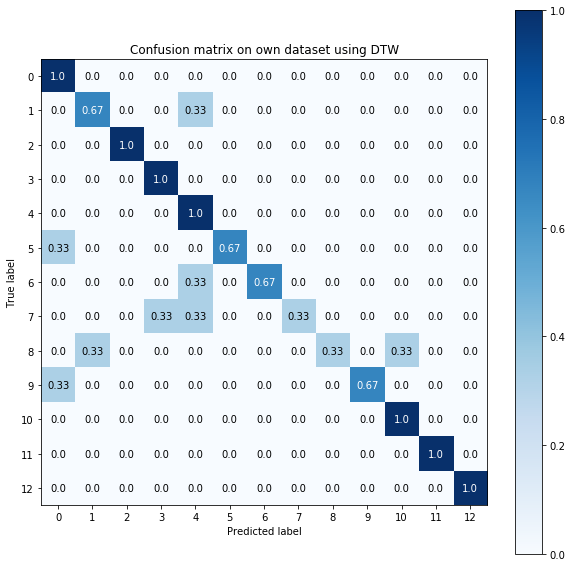

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.67      0.67      0.67         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       0.50      1.00      0.67         3
           5       1.00      0.67      0.80         3
           6       1.00      0.67      0.80         3
           7       1.00      0.33      0.50         3
           8       1.00      0.33      0.50         3
           9       1.00      0.67      0.80         3
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3

    accuracy                           0.79        39
   macro avg       0.87      0.79      0.78        39
weighted avg       0.87      0.79      0.78        39



In [766]:
yown_pred = recognie(X,Xown,y)
plot_eval(yown,yown_pred,title="Confusion matrix on own dataset using DTW")

### Apply DTW learn agrumented dataset

In [812]:
def moveData4DTW(path,dst_path,char=''):
    files = os.listdir(path)
    for file in files:
        copyfile(path+file, dst_path+char+file)

In [816]:
os.mkdir("datadtw_augr")
moveData4DTW("corpus/drone_withoutnoise/","datadtw_augr/")
moveData4DTW("corpus/drone_noise/","datadtw_augr/",'N')
moveData4DTW("corpus/pitch-15%/","datadtw_augr/",'P15')
moveData4DTW("corpus/pitch-25%/","datadtw_augr/",'P25')
moveData4DTW("corpus/pitch-50%/","datadtw_augr/",'P50')
moveData4DTW("corpus/pitch+15%/","datadtw_augr/",'M15')
moveData4DTW("corpus/pitch+25%/","datadtw_augr/",'M25')
moveData4DTW("corpus/pitch+50%/","datadtw_augr/",'M50')

In [817]:
Xarug,yarug = collect_data(dataset_name="datadtw_augr/")

In [818]:
Xarug_train,Xarug_test,yarug_train, yarug_test =train_test_split(Xarug, yarug, test_size=0.3,random_state=42)

In [ ]:
yarug_pred = recognie(X_train,X_test,y_train)
plot_eval(yarug_test,yarug_pred,title="Confusion matrix on agumented dataset using DTW")

## Part III: Comparison of dynamic programming with a classification method after data pre-processing

In this section, we will compare the results of DTW with those of a data classification method: the k-nearest neighbors (k-nn).

We will use the functions to calculate the PCA and k-nn via the python library *scikit-learn*.


In [768]:
labels = ["tournegauche","tournedroite","recule","plushaut",
          "plusbas","gauche","faisunflip","etatdurgence","droite",
          "decollage","avance","atterrissage","arretetoi"]

In [769]:
for label in labels:
    os.mkdir("data_augr/"+label)

In [770]:
def moveData(path,dst_path,labels,char=''):
    files = os.listdir(path)
    for label in labels:
        for file in files:
            if np.char.find(file,label) == 4:
                copyfile(path+file, dst_path+label+'/'+char+file)

### **Data agurmentation**
We use Audacity to change pitch with Frequency:
- plus 15%
- plus 25%
- plus 50%
- minus 15%
- minus 25%
- minus 50%

In [773]:
moveData("corpus/drone_withoutnoise/","data_augr/",labels)
moveData("corpus/drone_noise/","data_augr/",labels,'N00')
moveData("corpus/pitch-15%/","data_augr/",labels,'P15')
moveData("corpus/pitch-25%/","data_augr/",labels,'P25')
moveData("corpus/pitch-50%/","data_augr/",labels,'P50')
moveData("corpus/pitch+15%/","data_augr/",labels,'M15')
moveData("corpus/pitch+25%/","data_augr/",labels,'M25')
moveData("corpus/pitch+50%/","data_augr/",labels,'M50')

In [774]:
def collect_data_v3(dataset_name):
    X = []
    y = []
    files = glob2.glob(f'{dataset_name}/**/*.WAV')
    np.random.shuffle(files)
    for path in files:
        sample_class = path.split('/')[1]
        
        _,mfcc = wav2mfcc(path,max_len=60,n_mfcc = 12,pad=True,delta=True,delta_delta=True)
        X.append(mfcc)
        y.append(labels.index(sample_class))
    return np.array(X),y

In [775]:
X,y = collect_data_v3('data_augr')

In [796]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Training:",X_train.shape)
print("Test:",X_test.shape)

Training: (1352, 36, 60)
Test: (338, 36, 60)


#### seperate feature set into mfccs, delts, delts2 set and then flatten

In [797]:
nsamples, nx, ny = X_train.shape
X_f = X_train[:,:nx//3,:].reshape((nsamples,nx//3*ny))
Xdel_f = X_train[:,nx//3:nx//3*2,:].reshape((nsamples,nx//3*ny))
Xdel2_f = X_train[:,nx//3*2:,:].reshape((nsamples,nx//3*ny))

In [798]:
print("MFCCs",X_f.shape)
print("Dels",Xdel_f.shape)
print("Del2s",Xdel2_f.shape)

MFCCs (1352, 720)
Dels (1352, 720)
Del2s (1352, 720)


In [799]:
nsamples, nx, ny = X_test.shape
Xtest_f = X_test[:,:nx//3,:].reshape((nsamples,nx//3*ny))
Xtestdel_f = X_test[:,nx//3:nx//3*2,:].reshape((nsamples,nx//3*ny))
Xtestdel2_f = X_test[:,nx//3*2:,:].reshape((nsamples,nx//3*ny))

In [800]:
print("MFCCs",Xtest_f.shape)
print("Dels",Xtestdel_f.shape)
print("Del2s",Xtestdel2_f.shape)

MFCCs (338, 720)
Dels (338, 720)
Del2s (338, 720)


### Scaler data before applying PCA

In [801]:
scaler_f = sklearn.preprocessing.StandardScaler()
scaler_f.fit(X_f)
Xf_train = scaler_f.transform(X_f)
Xf_test = scaler_f.transform(Xtest_f)

scaler_del_f = sklearn.preprocessing.StandardScaler()
scaler_del_f.fit(Xdel_f)
Xdelf_train = scaler_del_f.transform(Xdel_f)
Xdelf_test = scaler_del_f.transform(Xtestdel_f)

scaler_del_f2 = sklearn.preprocessing.StandardScaler()
scaler_del_f2.fit(Xdel2_f)
Xdel2f_train = scaler_del_f2.transform(Xdel2_f)
Xdel2f_test = scaler_del_f2.transform(Xtestdel2_f)


#### PCA preprocessing

To test a classification method, the size of the MFCCs must first be reduced:

1. From all the records in the learning database, perform a Principal Component Analysis (PCA) using the *PCA* function of the *scikit-learn* library and then project the test data into this new database. 

*Note:* You can also implement the PCA by
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the
variance-covariance $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will constitute the new benchmark P. Then project the data from the learning and test database into this new database by multiplying each vector by the database $P =[X_1X_2X_3]$.


### Apply PCA foreach set (mfcc, del, del2) and choose fit n with 99% of variance

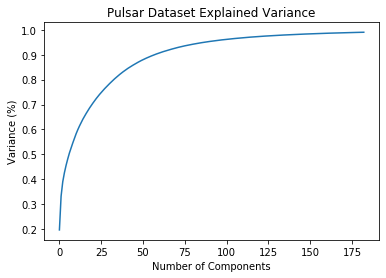

In [782]:
pca = sklearn.decomposition.PCA(0.99).fit(Xf_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

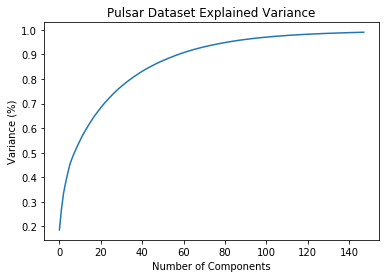

In [783]:
pca_del = sklearn.decomposition.PCA(0.99).fit(Xdelf_train)
plt.figure()
plt.plot(np.cumsum(pca_del.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

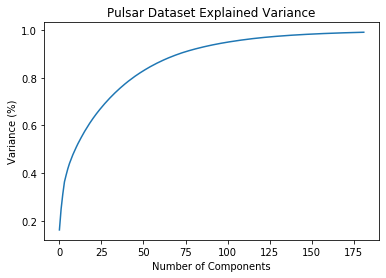

In [784]:
pca_del2 = sklearn.decomposition.PCA(0.99).fit(Xdel2f_train)
plt.figure()
plt.plot(np.cumsum(pca_del2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [786]:
def plot3d(X,y):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    colors = plt.cm.get_cmap('hsv', 13)
    for i in range(0,13):
        X_label = X[np.array(y)==i]
        ax.scatter(X_label[:,0],X_label[:,1], X_label[:,2]
                   ,label=labels[i], marker='o')
    ax.legend(loc='best')

### Apply PCA with n = 3

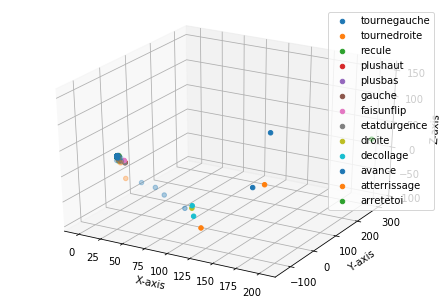

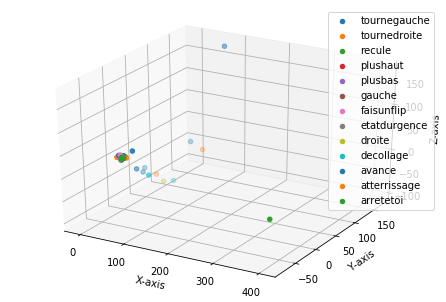

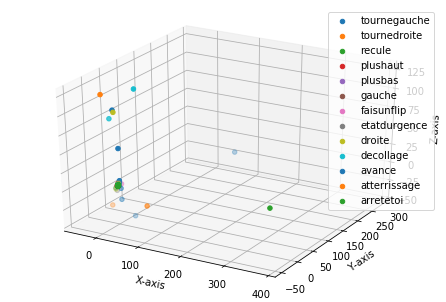

In [788]:
pca = sklearn.decomposition.PCA(n_components=3).fit(Xf_train)
X_train_reduce_f = pca.transform(Xf_train)
X_test_reduce_f = pca.transform(Xf_test)
plot3d(X_train_reduce_f,y_train)

pca_del = sklearn.decomposition.PCA(n_components=3).fit(Xdelf_train)
X_train_reduce_del = pca_del.transform(Xdelf_train)
X_test_reduce_del = pca_del.transform(Xdelf_test)
plot3d(X_train_reduce_del,y_train)

pca_del2 = sklearn.decomposition.PCA(n_components=3).fit(Xdel2f_train)
X_train_reduce_del2 = pca_del2.transform(Xdel2f_train)
X_test_reduce_del2 = pca_del2.transform(Xdel2f_test)
plot3d(X_train_reduce_del2,y_train)

#### Classification by k nearest neighbors

In artificial intelligence, the k nearest neighbor method (*k-nn*) is a supervised method. In this context, there is a learning database of "label-data" pairs. To estimate the output associated with a new input $x$, the $k$ nearest neighbor  method consists of taking into account (in the same way) the $k$ learning samples whose input is closest to the new input $x$, according to a distance to be defined. The associated algorithm and an example are given below.

<img src="files/knn.jpg" width="700" height="500" >

<img src="files/kppv.png" width="300" height="300" >

**Example of classification by k-nn.** The test sample (green circle) must be classified either in the first
class of blue squares, or in the second class of red triangles. 
If k = 3 (full circle), it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. 
If k = 5 (dotted circle), it is assigned to the first class (3 squares against 2 triangles inside the outer circle)


1. Using the *KNeighborsClassifier* function of the *sklearn.neighbors library*, perform a classification by k-nn on the learning and test basis you have predefined (take $k=1$).

2. Evaluate the k-nn method by calculating the confusion matrix and the recognition rate.

3. Change the value of $k$ for k-nn. Do you improve recognition scores?

4. Compare your results with those of DTW.

In [267]:
def pca(Xf_train,Xf_test,Xdelf_train,Xdelf_test,Xdel2f_train,Xdel2f_test,n):
    pca = sklearn.decomposition.PCA(n_components=n).fit(Xf_train)
    X_train_reduce_f = pca.transform(Xf_train)
    X_test_reduce_f = pca.transform(Xf_test)

    pca_del = sklearn.decomposition.PCA(n_components=n).fit(Xdelf_train)
    X_train_reduce_del = pca_del.transform(Xdelf_train)
    X_test_reduce_del = pca_del.transform(Xdelf_test)

    pca_del2 = sklearn.decomposition.PCA(n_components=n).fit(Xdel2f_train)
    X_train_reduce_del2 = pca_del2.transform(Xdel2f_train)
    X_test_reduce_del2 = pca_del2.transform(Xdel2f_test)

    X_train_reduce = np.concatenate((X_train_reduce_f, X_train_reduce_del,X_train_reduce_del2),axis=1)
    X_test_reduce = np.concatenate((X_test_reduce_f, X_test_reduce_del,X_test_reduce_del2),axis=1)
    
    return X_train_reduce,X_test_reduce

In [268]:
def model_input_m(mfcc,scaler_f,scaler_del_f,scaler_del_f2,pca,pca_del,pca_del2):
    m,nx, ny = mfcc.shape
    X_f = mfcc[:,:nx//3,:].reshape((m,nx//3*ny))
    Xdel_f = mfcc[:,nx//3:nx//3*2,:].reshape((m,nx//3*ny))
    Xdel2_f = mfcc[:,nx//3*2:,:].reshape((m,nx//3*ny))
    
    Xf_test = scaler_f.transform(X_f)
    Xdelf_test = scaler_del_f.transform(Xdel_f)
    Xdel2f_test = scaler_del_f2.transform(Xdel2_f)
    
    X_test_reduce_f = pca.transform(Xf_test)
    X_test_reduce_del = pca_del.transform(Xdelf_test)
    X_test_reduce_del2 = pca_del2.transform(Xdel2f_test)
    
    X_test_reduce = np.concatenate((X_test_reduce_f, X_test_reduce_del,X_test_reduce_del2),axis=1)

    return X_test_reduce

In [269]:
def collect_test(path,ik):
    X = []
    y = []
    for file in os.listdir(path):
        sample_class = file.split('_')[1]
        
        y.append(labels.index(sample_class[:len(sample_class)-4]))
        _, mfcc = wav2mfcc(path+file,max_len=100,n_mfcc = 13,pad=True,delta=True,delta_delta=True)
        X.append(mfcc)
    return np.array(X),y

In [270]:
X_testF,y_testF = collect_test('drone_custom_new/',ik='A')

In [795]:
X_test.shape

(338, 36, 60)

In [802]:
grid_params = {
    'n_neighbors': np.arange(2, 25),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

pca = sklearn.decomposition.PCA(0.99).fit(Xf_train)
X_train_reduce_f = pca.transform(Xf_train)
X_test_reduce_f = pca.transform(Xf_test)

pca_del = sklearn.decomposition.PCA(0.99).fit(Xdelf_train)
X_train_reduce_del = pca_del.transform(Xdelf_train)
X_test_reduce_del = pca_del.transform(Xdelf_test)

pca_del2 = sklearn.decomposition.PCA(0.99).fit(Xdel2f_train)
X_train_reduce_del2 = pca_del2.transform(Xdel2f_train)
X_test_reduce_del2 = pca_del2.transform(Xdel2f_test)

X_train_reduce = np.concatenate((X_train_reduce_f, X_train_reduce_del,X_train_reduce_del2),axis=1)
X_test_reduce = np.concatenate((X_test_reduce_f, X_test_reduce_del,X_test_reduce_del2),axis=1)

clf = KNeighborsClassifier()
knn_gscv = GridSearchCV(clf, grid_params, cv=6)

knn_gscv.fit(X_train_reduce, y_train)

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [803]:
print(knn_gscv.best_params_, knn_gscv.best_score_)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9275147928994083


In [804]:
knn_gscv.score(X_test_reduce,y_test)

0.9319526627218935

In [805]:
y_pred = knn_gscv.predict(X_test_reduce)

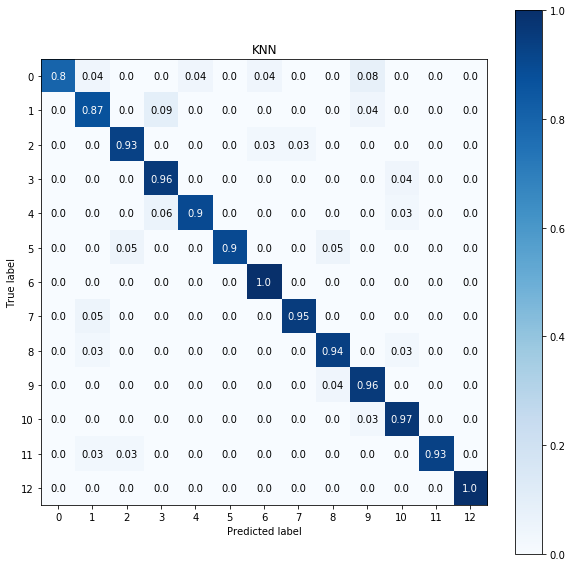

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.83      0.87      0.85        23
           2       0.93      0.93      0.93        29
           3       0.85      0.96      0.90        23
           4       0.97      0.90      0.93        31
           5       1.00      0.90      0.95        21
           6       0.93      1.00      0.97        28
           7       0.95      0.95      0.95        22
           8       0.94      0.94      0.94        31
           9       0.85      0.96      0.90        24
          10       0.91      0.97      0.94        31
          11       1.00      0.93      0.96        29
          12       1.00      1.00      1.00        21

    accuracy                           0.93       338
   macro avg       0.94      0.93      0.93       338
weighted avg       0.94      0.93      0.93       338



In [806]:
plot_eval(y_test,y_pred,"KNN")

MC1_faisunflip.wav recule
C01_droite.wav droite
C01_faisunflip.wav faisunflip
C01_plushaut.wav plushaut
C02_tournegauche.wav tournegauche
C02_atterrissage.wav atterrissage
MC1_gauche.wav gauche
MC1_tournedroite.wav tournedroite
MC1_etatdurgence.wav arretetoi
C01_arretetoi.wav arretetoi
C02_recule.wav recule
C01_gauche.wav gauche
C02_faisunflip.wav faisunflip
MC1_plusbas.wav plusbas
C02_etatdurgence.wav etatdurgence
MC1_decollage.wav decollage
C02_tournedroite.wav tournedroite
C02_avance.wav avance
MC1_atterrissage.wav atterrissage
C02_arretetoi.wav arretetoi
MC1_tournegauche.wav tournegauche
MC1_droite.wav droite
MC1_plushaut.wav plushaut
C01_avance.wav avance
C01_plusbas.wav plusbas
C01_tournedroite.wav tournedroite
C01_etatdurgence.wav etatdurgence
C01_recule.wav recule
C02_gauche.wav gauche
C02_decollage.wav decollage
MC1_recule.wav recule
MC1_arretetoi.wav arretetoi
C01_atterrissage.wav atterrissage
C02_plusbas.wav plusbas
MC1_avance.wav avance
C02_plushaut.wav plushaut
C01_decolla

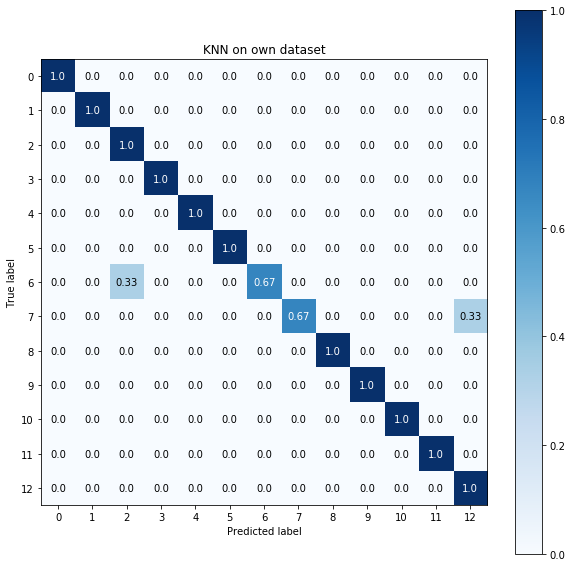

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3

    accuracy                           0.95        39
   macro avg       0.96      0.95      0.95        39
weighted avg       0.96      0.95      0.95        39



In [808]:
y_true = []
y_pred = []
for file in os.listdir("drone_custom_new"):
    sample_class = file.split('_')[1]
    y_true.append(labels.index(sample_class[:(len(sample_class)-4)]))
    _, mfcc_thang = wav2mfcc('drone_custom_new/'+file,max_len=60,n_mfcc = 12,pad=True,delta=True,delta_delta=True)
    mfcc_thang = model_input(mfcc_thang,scaler_f,scaler_del_f,scaler_del_f2,pca,pca_del,pca_del2)
    y_ = knn_gscv.predict(mfcc_thang)
    y_pred.append(y_)
    print(file, labels[y_[0]])
plot_eval(y_true,y_pred,title="KNN on own dataset")